In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


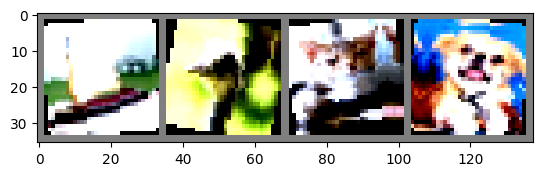

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(0.05)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(0.05)
        ) # output_size = 30
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
            #nn.ReLU(),
            #nn.GroupNorm(num_groups=2, num_channels=10),
            #nn.Dropout(0.1)
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(0.05)
        ) # output_size = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(0.05)
        ) # output_size = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.Dropout(0.05)
        ) # output_size = 12
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.GroupNorm(num_groups=2, num_channels=10),
            #nn.Dropout(0.1)
        ) # output_size = 12
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 6
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=8, num_channels=32),
            nn.Dropout(0.05)
        ) # output_size = 6
        # OUTPUT BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=8, num_channels=32),
            nn.Dropout(0.05)
        ) # output_size = 6
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            #nn.ReLU(),
            #nn.GroupNorm(num_groups=2, num_channels=10),
            #nn.Dropout(0.1)
        ) # output_size = 4
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
                   ) # output_size =
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                    )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda


You should consider upgrading via the 'D:\Environment\ERA_V2\Scripts\python.exe -m pip install --upgrade pip' command.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 30, 30]           4,608
              ReLU-6           [-1, 32, 30, 30]               0
         GroupNorm-7           [-1, 32, 30, 30]              64
           Dropout-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 10, 32, 32]             320
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
        GroupNorm-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1, 16,

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)
scheduler = StepLR(optimizer, step_size=13, gamma=0.08)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4956560134887695 Batch_id=390 Accuracy=36.41: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 1.4965, Accuracy: 4521/10000 (45.21%)

EPOCH: 1


Loss=1.49767005443573 Batch_id=390 Accuracy=46.90: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]  



Test set: Average loss: 1.2839, Accuracy: 5412/10000 (54.12%)

EPOCH: 2


Loss=1.274984359741211 Batch_id=390 Accuracy=53.05: 100%|██████████| 391/391 [00:36<00:00, 10.85it/s] 



Test set: Average loss: 1.1658, Accuracy: 5782/10000 (57.82%)

EPOCH: 3


Loss=1.2856183052062988 Batch_id=390 Accuracy=56.44: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s]



Test set: Average loss: 1.0691, Accuracy: 6150/10000 (61.50%)

EPOCH: 4


Loss=1.1872984170913696 Batch_id=390 Accuracy=59.64: 100%|██████████| 391/391 [00:34<00:00, 11.17it/s]



Test set: Average loss: 1.0646, Accuracy: 6228/10000 (62.28%)

EPOCH: 5


Loss=1.141499400138855 Batch_id=390 Accuracy=61.04: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s] 



Test set: Average loss: 0.9504, Accuracy: 6574/10000 (65.74%)

EPOCH: 6


Loss=0.9764259457588196 Batch_id=390 Accuracy=62.31: 100%|██████████| 391/391 [00:37<00:00, 10.40it/s]



Test set: Average loss: 0.9289, Accuracy: 6683/10000 (66.83%)

EPOCH: 7


Loss=0.956889808177948 Batch_id=390 Accuracy=63.74: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s] 



Test set: Average loss: 0.8990, Accuracy: 6846/10000 (68.46%)

EPOCH: 8


Loss=0.9249361753463745 Batch_id=390 Accuracy=64.58: 100%|██████████| 391/391 [00:37<00:00, 10.56it/s]



Test set: Average loss: 0.8931, Accuracy: 6851/10000 (68.51%)

EPOCH: 9


Loss=0.7767917513847351 Batch_id=390 Accuracy=65.34: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]



Test set: Average loss: 0.8541, Accuracy: 6989/10000 (69.89%)

EPOCH: 10


Loss=0.8667837977409363 Batch_id=390 Accuracy=66.25: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]



Test set: Average loss: 0.8283, Accuracy: 7095/10000 (70.95%)

EPOCH: 11


Loss=0.8105866312980652 Batch_id=390 Accuracy=66.89: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 0.8092, Accuracy: 7152/10000 (71.52%)

EPOCH: 12


Loss=0.8800803422927856 Batch_id=390 Accuracy=67.42: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]



Test set: Average loss: 0.7756, Accuracy: 7260/10000 (72.60%)

EPOCH: 13


Loss=0.990902304649353 Batch_id=390 Accuracy=70.69: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s] 



Test set: Average loss: 0.7228, Accuracy: 7437/10000 (74.37%)

EPOCH: 14


Loss=0.7865962386131287 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.7138, Accuracy: 7481/10000 (74.81%)

EPOCH: 15


Loss=0.8803736567497253 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]



Test set: Average loss: 0.7134, Accuracy: 7501/10000 (75.01%)

EPOCH: 16


Loss=1.0089638233184814 Batch_id=390 Accuracy=71.86: 100%|██████████| 391/391 [00:34<00:00, 11.17it/s]



Test set: Average loss: 0.7069, Accuracy: 7502/10000 (75.02%)

EPOCH: 17


Loss=0.7946648001670837 Batch_id=390 Accuracy=72.11: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.6983, Accuracy: 7542/10000 (75.42%)

EPOCH: 18


Loss=0.9952777028083801 Batch_id=390 Accuracy=72.23: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.6980, Accuracy: 7547/10000 (75.47%)

EPOCH: 19


Loss=0.6624898314476013 Batch_id=390 Accuracy=72.35: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 0.6913, Accuracy: 7577/10000 (75.77%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

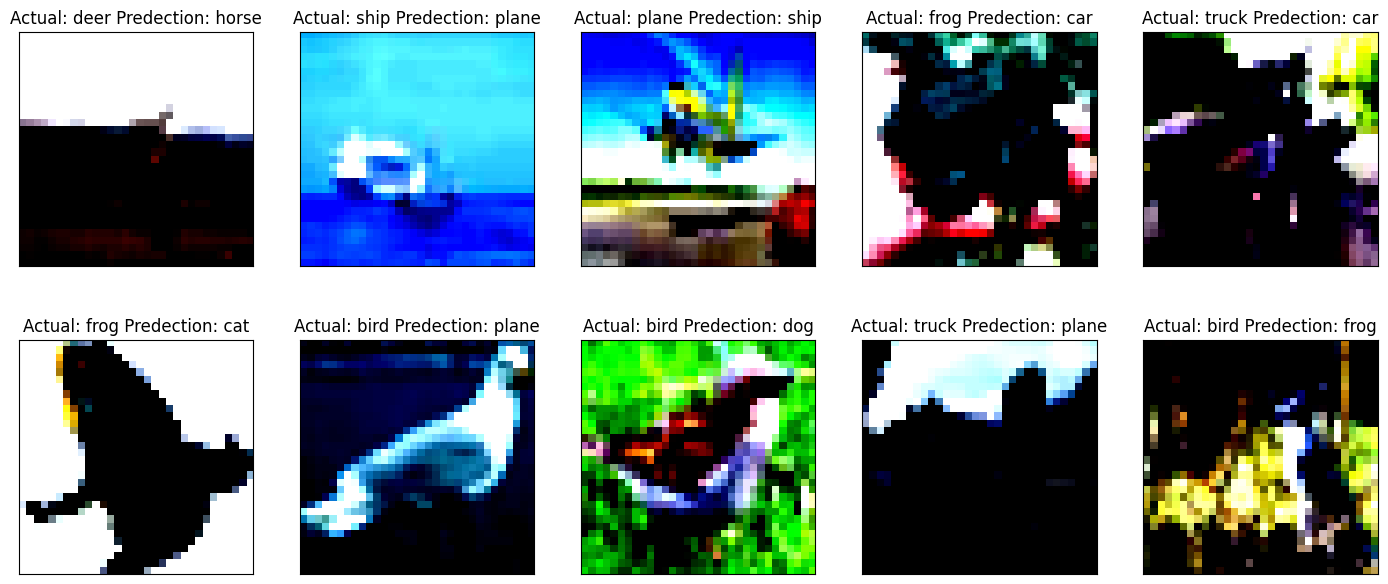

In [10]:
import matplotlib.pyplot as plt
import numpy as np
model.eval()
with torch.no_grad():
    batch_data, batch_label = next(iter(test_loader))
    batch_data, batch_label = batch_data.to(device), batch_label.to(device)
    prediction = model(batch_data)
    prediction_class = np.argmax(prediction.cpu().numpy(), axis=1)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
        # Check if the prediction is incorrect
    for i in range(len(prediction_class)): 
        if prediction_class[i] != batch_label[i].cpu().numpy():
        
            img = batch_data[i].permute(1, 2, 0)
            misclassified_images.append(img)
            misclassified_labels.append(classes[batch_label[i].item()])
            misclassified_predictions.append(classes[prediction_class[i]])


fig = plt.figure(figsize=(14,7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.tight_layout()
    img = misclassified_images[i]
    class_name = misclassified_predictions[i]
    plt.imshow(img.cpu())
    plt.title(f'Actual: {misclassified_labels[i]} Predection: {class_name}')
    plt.xticks([])
    plt.yticks([])


In [11]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

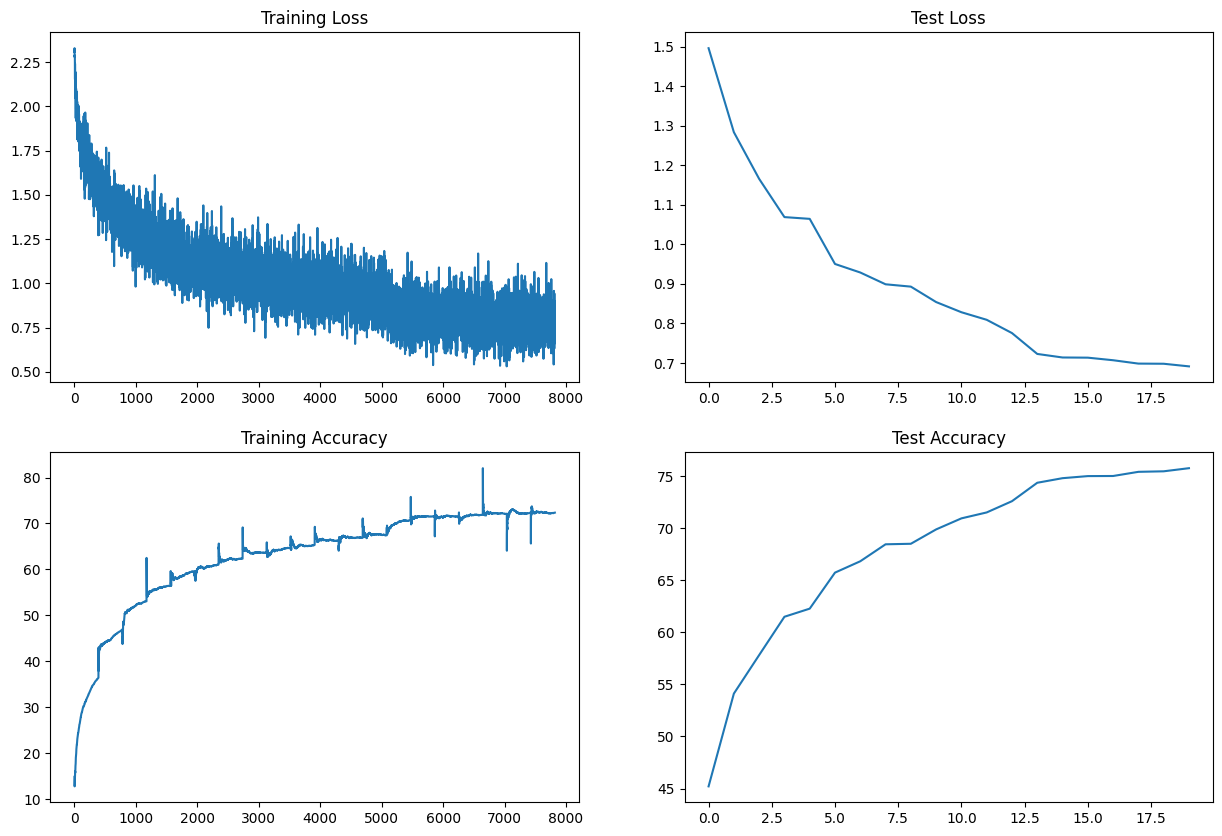

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")